In [1]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import cv2
import heapq
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
import math
import pandas as pd
import pickle

In [2]:
# define the dimensions and color of the cost map
width = 32
height = 32
color = (255, 255, 255)

In [3]:
def generate_random_maps(width, height, obstacle_prob):
    # Initialize an empty map
    map = [[0 for x in range(width)] for y in range(height)]
    
    # Place obstacles randomly
    for y in range(height):
        for x in range(width):
            if random.random() < obstacle_prob:
                map[y][x] = 1
    
    # Generate random start and end points
    start_x, start_y = random.randint(0, width-1), random.randint(0, height-1)
    end_x, end_y = random.randint(0, width-1), random.randint(0, height-1)
    
    # If start and end points are the same, regenerate end point
    while start_x == end_x and start_y == end_y:
        end_x, end_y = random.randint(0, width-1), random.randint(0, height-1)
    
    # Place start and end points on the map
    map[start_y][start_x] = 2
    map[end_y][end_x] = 3
    
    return map

In [4]:
def a_star(start, goal, grid):
    # Define the heuristic function
    def heuristic(a, b):
        # Use Euclidean distance as the heuristic
        return math.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)
    
    # Define the neighbors function
    def neighbors(point):
        x, y = point
        results = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
        results = filter(lambda p: 0 <= p[0] < len(grid) and 0 <= p[1] < len(grid[0]), results)
        results = filter(lambda p: grid[p[0]][p[1]] == 0, results)
        return results
    
    # Initialize the open and closed sets
    open_set = []
    closed_set = set()
    
    # Add the starting point to the open set
    heapq.heappush(open_set, (0, start))
    
    # Initialize the cost and came_from dictionaries
    cost = {start: 0}
    came_from = {}
    
    # Loop until the open set is empty
    while open_set:
        # Pop the lowest-cost point from the open set
        current_cost, current_point = heapq.heappop(open_set)
        
        # If the current point is the goal, reconstruct and return the path
        if current_point == goal:
            path = [current_point]
            while current_point in came_from:
                current_point = came_from[current_point]
                path.append(current_point)
            path.reverse()
            return path
        
        # Add the current point to the closed set
        closed_set.add(current_point)
        
        # Loop through the current point's neighbors
        for neighbor in neighbors(current_point):
            # Calculate the tentative cost to the neighbor
            tentative_cost = cost[current_point] + 1
            
            # If the neighbor is already in the closed set and the new cost is greater than or equal to the old cost, skip it
            if neighbor in closed_set and tentative_cost >= cost.get(neighbor, float('inf')):
                continue
            
            # If the neighbor is not in the open set or the new cost is less than the old cost, add it to the open set
            if tentative_cost < cost.get(neighbor, float('inf')):
                came_from[neighbor] = current_point
                cost[neighbor] = tentative_cost
                priority = tentative_cost + heuristic(goal, neighbor)
                heapq.heappush(open_set, (priority, neighbor))
    
    # If the open set is empty and the goal has not been reached, there is no path
    return None

In [5]:
def distance(p1, p2):
    # Calculate the Euclidean distance between two points
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

In [6]:
def find_start_end(map):
    # Find the start and end points
    start, end = None, None
    for y in range(len(map)):
        for x in range(len(map[0])):
            if map[y][x] == 2:
                start = (x, y)
            elif map[y][x] == 3:
                end = (x, y)
            if start is not None and end is not None:
                return start, end
    # If start and end points are not found, raise an error
    raise ValueError("Start or end point not found in map")

In [7]:
# Define the colors used for the map and path
COLOR_MAP = (255, 255, 255)  # white
COLOR_OBSTACLE = (0, 0, 0)  # black
COLOR_START = (0, 255, 0)  # green
COLOR_GOAL = (0, 0, 255)  # red
COLOR_PATH = (0, 0, 0)  # blue

# Define the size of each cell in the image
CELL_SIZE = 1

def create_map_image(map):
    # Create a blank image with the correct dimensions
    image = np.zeros((len(map) * CELL_SIZE, len(map[0]) * CELL_SIZE, 3), dtype=np.uint8)
    # start, goal = find_start_end(map)

    # Loop through each cell in the map and draw it in the image
    for i in range(len(map)):
        for j in range(len(map[0])):
            # Determine the color of the cell
            if map[i][j] == 1:
                color = COLOR_OBSTACLE
            else:
                color = COLOR_MAP
            
            # Draw the cell in the image
            x = j * CELL_SIZE
            y = i * CELL_SIZE
            cv2.rectangle(image, (x, y), (x + CELL_SIZE, y + CELL_SIZE), color, -1)
    
    return image

In [8]:
def draw_path_on_image(image, path):
    # Loop through each point in the path and draw it on the image
    for i in range(len(path)-1):
        # Determine the coordinates of the two points
        x1 = path[i][1] * CELL_SIZE + CELL_SIZE // 2
        y1 = path[i][0] * CELL_SIZE + CELL_SIZE // 2
        x2 = path[i+1][1] * CELL_SIZE + CELL_SIZE // 2
        y2 = path[i+1][0] * CELL_SIZE + CELL_SIZE // 2
        
        # Draw a line between the two points
        cv2.line(image, (x1, y1), (x2, y2), COLOR_PATH, 1)
    
    return image

In [9]:
def generate_random_start_and_goal(map):
    # Define the minimum distance between the start and goal points
    min_distance = max(len(map), len(map[0])) // 2
    
    # Choose random start and goal points that are not too close
    while True:
        start = (random.randint(0, len(map)-1), random.randint(0, len(map[0])-1))
        goal = (random.randint(0, len(map)-1), random.randint(0, len(map[0])-1))
        if distance(start, goal) >= min_distance:
            return start, goal

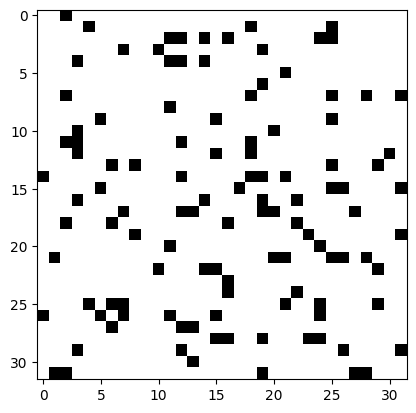

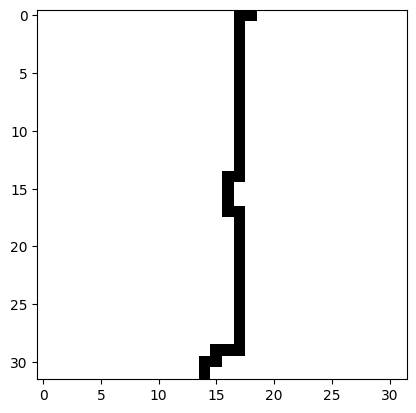

In [12]:
# Generate a random map
map = generate_random_maps(32, 32, 0.1)

# Generate random start and goal points
start, goal = find_start_end(map)

# Run the A* algorithm to find the path
path = a_star(start, goal, map)
if path == "None":
  print("No path found")

# Create an image of the map
map_image = create_map_image(map)

# Draw the path on the image
# create a new image with the specified dimensions and color
new_img = np.array(Image.new('RGB', (width, height), color))
path_image = draw_path_on_image(new_img, path)

# Display the images
plt.imshow(cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(path_image)  
plt.show()


In [13]:
start_end = []

In [14]:
# Step 1: Generating a labeled dataset
def generate_dataset(n):
    global start_end
    map_images = []
    path_images = []
    is_start_end = []
    i = 0
    while i != n:
        map_data = generate_random_maps(32, 32, 0.1)
        map_image = create_map_image(map_data)
        start, goal = find_start_end(map_data)
        path = a_star(start, goal, map)
        if path is not None:
            arr1 = [0]*32*32
            arr1[start[0]*32 + start[1]] = 1
            arr1[goal[0]*32 + goal[1]] = 1
            is_start_end = is_start_end + arr1
            new_img = np.array(Image.new('RGB', (width, height), color))
            path_image = draw_path_on_image(new_img, path)
            map_image = cv2.cvtColor(map_image, cv2.COLOR_BGR2GRAY)
            path_image = cv2.cvtColor(path_image, cv2.COLOR_BGR2GRAY)
            path_image = (path_image.astype(np.float32) / 255.0)
            map_image = map_image.reshape(-1)
            path_image = path_image.reshape(-1)
            map_images.append(map_image)
            path_images.append(path_image)
            start_end.append((start, goal))
            i+=1
    return np.array(map_images), np.array(path_images), np.array(is_start_end)

In [15]:
X, Y, Z = generate_dataset(500)

In [166]:
# first_img = X[0].reshape((32, 32, 1))
# plt.imshow(first_img, cmap="gray")
# plt.show()

In [17]:
np.unique(Y)

array([0., 1.], dtype=float32)

In [18]:
print(X[0].shape)
print(Y[0].shape)

(1024,)
(1024,)


In [19]:
print(X.shape)
print(Y.shape)

(500, 1024)
(500, 1024)


In [20]:
X = X.flatten()
Y = Y.flatten()
print(X.shape, Y.shape, Z.shape)
print(X.shape)

(512000,) (512000,) (512000,)
(512000,)


In [21]:
print(Y[0])
Y = Y.reshape(-1)
Y.shape

1.0


(512000,)

In [22]:
X_Z = np.column_stack((X, Z))
print(X_Z[0])
df = pd.DataFrame(X_Z)
df

[255   0]


,0,1
0,255,0
1,255,0
2,255,0
3,255,0
4,255,0
...,...,...
511995,255,0
511996,255,0
511997,255,0
511998,255,0


In [167]:
X_train, X_test, Y_train, Y_test = train_test_split(df, Y, test_size=0.2, random_state=42)

In [36]:
# Step 3: Training an SVM model
clf = svm.SVR(kernel='sigmoid', C=1)
clf.fit(X_train, Y_train)

SVR(C=1, kernel='sigmoid')

In [37]:
s = pickle.dumps(clf)

In [152]:
# Generate a random map
test_map = generate_random_maps(32, 32, 0.1)
test_map_image = create_map_image(test_map)

# Generate random start and goal points
test_start, test_goal = find_start_end(map)

In [198]:
# Step 4: Classifying all cells in the cost map
traversable_map = clf.predict(X_test.iloc[0:1024]).reshape(-1, 1) #1024 outputs for 1 point

In [199]:
print(traversable_map.shape)
np.unique(traversable_map)

(1024, 1)


array([0.89473256, 0.9       , 0.9       ])

In [170]:
img_arr = []
for i in traversable_map:
    if i >= 0.9:
        img_arr.append(0)
    else:
        img_arr.append(1)

img_arr = np.array(img_arr)

In [171]:
np.unique(img_arr)
img_arr.shape

(1024,)

In [172]:
img_arr = img_arr.reshape((32, 32, 1))
img_arr.shape

(32, 32, 1)

In [186]:
test_image = X_test.iloc[0:1024][0].values
test_image.shape

(1024,)

In [187]:
test_image = test_image.reshape((32, 32, 1))
test_image.shape

(32, 32, 1)

Traversable Area found

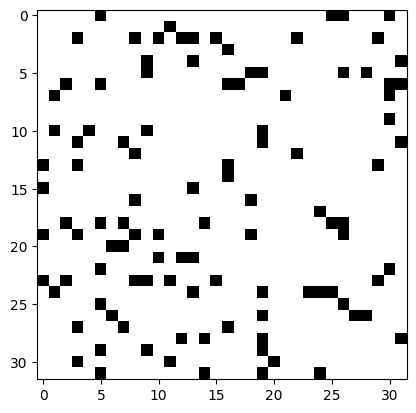

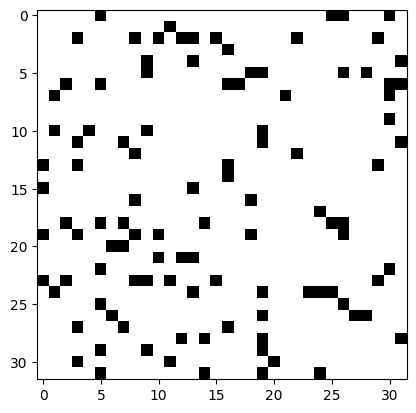

In [188]:
plt.imshow(test_image, cmap="gray")
plt.show()
plt.imshow(img_arr, cmap="gray")
plt.show()

In [195]:
#--- take the absolute difference of the images ---
res = cv2.absdiff(test_image.astype('uint8'), img_arr)

#--- convert the result to integer type ---
res = res.astype(np.uint8)

#--- find percentage difference based on number of pixels that are not zero ---
percentage = (np.count_nonzero(res) * 100)/ res.size

In [205]:
print(percentage,"%")

81.25%
